In [32]:
%matplotlib inline
# useful additional packages 

#import math tools
import numpy as np

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

# importing Qiskit
import qiskit as qk

qk.IBMQ.load_account()
provider = qk.IBMQ.get_provider(group='open')
print(provider.backends())
# Run the quantum circuit on a specific backend
BACKEND1 = provider.get_backend('ibmq_vigo')
# BACKEND1 = qk.Aer.get_backend('qasm_simulator')
BACKEND2 = qk.Aer.get_backend('qasm_simulator')
backend = qk.Aer.get_backend('qasm_simulator')
#backend = provider.get_backend('ibmq_vigo')

# from qiskit import Aer, IBMQ
# from qiskit.providers.ibmq      import least_busy
# from qiskit.tools.monitor       import job_monitor
# from qiskit.visualization import plot_histogram

import collections



Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]


## Config Parameters and Constants##

In [2]:
PI = np.pi
NSHOTS = 1024
SEED = 12345

## Helper Function Definitions

In [3]:
def get_ZZ(qbs, pair):
    '''
    qbs: qubit string i.e. "0010"
    pair: ZmZn i.e. (0,1)
    '''
    qbs_r = qbs[::-1]
    return -((qbs_r[pair[0]] != qbs_r[pair[1]])-.5) * 2

get_ZZ("1010", (1,2))

-1.0

In [4]:
def get_max_cut_value(qbs, pair):
    '''
    qbs: qubit string i.e. "0010"
    pair: ZmZn i.e. (0,1)
    '''
    qbs_r = qbs[::-1]
    return (qbs_r[pair[0]] != qbs_r[pair[1]])

In [5]:
def make_maxcut_circuit(n, depth, thetas):
    '''
    n: number of qubits:
    depth: number of entanglements; 
    thetas: the control parameters for VQE; dimension = (n,depth)
    '''
    # parameter sanity check: check if the dimension is okay
    if isinstance(thetas, collections.Iterable) and len(thetas) >= n:
        for idx in range(n):
            if isinstance(thetas[idx], collections.Iterable) and len(thetas) >= depth: 
                pass
            else:
                raise TypeError("thetas[%d] is not an iterable or it has dimension smaller than depth = %d" % (idx,depth))
    else:
        raise TypeError("thetas is not an iterable or it has dimension smaller than n = %d" % n)
        
    # construct qubits and classical bits    
    qr = qk.QuantumRegister(n, 'q')
    cr = qk.ClassicalRegister(n, 'c')
    qc = qk.QuantumCircuit(qr, cr)
    
    for d in range(depth):
        # assign parameterized U3
        for qb in range(n):
            qc.u3(thetas[qb][d],0,0, qr[qb])
        # add barrier
        qc.barrier(qr)
        
        # pairwise control Z
        for cqb in range(n-1):
            qc.cz(qr[cqb],qr[cqb + 1])
        pass
        # add barrier
        qc.barrier(qr)
    
    # measure z
    for qb in range(n):
        qc.measure(qr[qb],cr[qb])
    return qc,qr,qc


def get_orig_maxcut_result(n,depth,default_thetas):
    cc,qr,qc = make_maxcut_circuit(n,depth,default_thetas)
    {qr[0]: 0,
                     qr[1]: 1,
                     qr[2]: 2}
    job = qk.execute(cc, BACKEND1,shots=NSHOTS, seed_simulator=SEED, 
                     initial_layout={qr[0]: 0, qr[1] : 1, qr[2] : 3, qr[3] : 4})
    result = job.result()
    ddict = result.get_counts(0)
    for idx in range(2 ** n):
        if not (format(idx, "0%db" % n) in ddict):
            ddict[format(idx,'0%db'% n)] = 0
    return ddict

In [6]:
def get_reduced_maxcut_result(n, depth, thetas):
    '''
        returns the result in n qubit space
        by default the qubit to be disconnected is the last qubit with index n-1
    '''
    # parameter sanity check: check if the dimension is okay
    if isinstance(thetas, collections.Iterable) and len(thetas) >= n:
        for idx in range(n):
            if isinstance(thetas[idx], collections.Iterable) and len(thetas) >= depth: 
                pass
            else:
                raise TypeError("thetas[%d] is not an iterable or it has dimension smaller than depth = %d" % (idx,depth))
    else:
        raise TypeError("thetas is not an iterable or it has dimension smaller than n = %d" % n)
        
    # construct container for n-1 qubit results
    final_result = {}
    for idx in range(2 ** n):
        final_result[format(idx,'0%db'% n)] = 0
  
    counts = [0 for i in range(6 ** depth)] # keeps track of all the counts of all the power of 
    for runid in range(6 ** depth):
        # the index of the version at each two qubit gate we split
        cc_cnts = [ (runid % (6 ** (idx + 1))) // (6 ** idx) for idx in range(depth)]
        # construct qubits and classical bits
        qr = qk.QuantumRegister(n-1, 'q')
        cr = qk.ClassicalRegister(n-1+depth, 'c')
        qc = qk.QuantumCircuit(qr, cr)
        qc2 =qk.QuantumCircuit(1, 1+depth) 
      
        #coef for each runid
        coef = 1

        for d in range(depth):
            # assign parameterized U3
            for qb in range(n-1):
                qc.u3(thetas[qb][d],0,0, qr[qb])
            qc2.u3(thetas[-1][d],0,0, 0)
            
            # add barrier
            qc.barrier(qr)
            qc2.barrier([0])

            # pairwise control Z
            for cqb in range(n-2):
                qc.cz(qr[cqb],qr[cqb + 1])
            
            # add the virtual two qubit gate on the last qubit
            gate_ver = cc_cnts[d] + 1
            qa = qr[-1]
            qb = 0
            if gate_ver == 1:
                coef *= 1/2
            elif gate_ver == 2:
                qc.z(qa)
                qc2.z(qb)
                coef *= 1/2
            elif gate_ver == 3:
                qc.measure(qa, cr[n-1+d])
                qc2.rz(-np.pi * 1 / 2, qb)
    
                coef *= -1/2*1
            elif gate_ver == 4:
                qc.measure(qa, cr[n-1+d])
                qc2.rz(-np.pi * -1 / 2, qb)
    
                coef *= -1/2*-1
            elif gate_ver == 5:
                qc2.measure(qb, 1+d)
                qc.rz(-np.pi * 1 / 2, qa)
    
                coef *= -1/2*1
            elif gate_ver == 6:
                qc2.measure(qb, 1+d)
                qc.rz(-np.pi * -1 / 2, qa)
    
                coef *= -1/2*-1
            
            qc.rz(-np.pi/2,qa)
            qc2.rz(-np.pi/2,qb)
            qc.barrier(qr)
            qc2.barrier([0])
    
        # measure z
        for qb in range(n-1):
            qc.measure(qr[qb],cr[qb])
        qc2.measure([0], [0])
    
        # execute experiments
        job_tmp_1 = qk.execute(qc, BACKEND1,shots=NSHOTS, seed_simulator=SEED)
        job_tmp_2 = qk.execute(qc2, BACKEND2,shots=NSHOTS, seed_simulator=SEED)
        result_tmp_2 = job_tmp_2.result()
        result_tmp_1 = job_tmp_1.result()
        dict_1 = result_tmp_1.get_counts(0)
        dict_2 = result_tmp_2.get_counts(0)
        
        for key1 in dict_1:
            coef1 = 1
            for i in key1[0:depth]:
                coef1 *= 1-int(i)*2
            for key2 in dict_2:
                coef2 = 1
                for i in key2[0:depth]:
                    coef2 *= 1-int(i)*2
                #print(key2[depth:], ' ', key2[-1])
                key = key2[depth:] + key1[depth:]
                #print(key)
                final_result[key] += coef*coef1*coef2*dict_1[key1]*dict_2[key2]
    #print(final_result)
    return final_result

In [7]:
def get_cost(data, w):
    d = len(w)
    cnt = np.sum(list(data.values()))
    cost = 0
    for mm in range(d):
        for nn in range(mm+1,d):
            cost += w[mm][nn] * np.sum([get_max_cut_value(val,(mm,nn)) * data[val] for val in data])
    return cost / cnt

In [33]:
def get_real_device_reduced_maxcut_result(n, depth, thetas):
    '''
        returns the result in n qubit space
        by default the qubit to be disconnected is the last qubit with index n-1
    '''
    # parameter sanity check: check if the dimension is okay
    if isinstance(thetas, collections.Iterable) and len(thetas) >= n:
        for idx in range(n):
            if isinstance(thetas[idx], collections.Iterable) and len(thetas) >= depth: 
                pass
            else:
                raise TypeError("thetas[%d] is not an iterable or it has dimension smaller than depth = %d" % (idx,depth))
    else:
        raise TypeError("thetas is not an iterable or it has dimension smaller than n = %d" % n)
        
    # construct container for n-1 qubit results
    final_result = {}
    for idx in range(2 ** n):
        final_result[format(idx,'0%db'% n)] = 0
  
    counts = [0 for i in range(6 ** depth)] # keeps track of all the counts of all the power of 
    for runid in range(6 ** depth):
        # the index of the version at each two qubit gate we split
        cc_cnts = [ (runid % (6 ** (idx + 1))) // (6 ** idx) for idx in range(depth)]
        # construct qubits and classical bits
        qr = qk.QuantumRegister(n-1, 'q')
        cr = qk.ClassicalRegister(n-1, 'c')
        qc = qk.QuantumCircuit(qr, cr)
        qc2 =qk.QuantumCircuit(1, 1) 
      
        #coef for each runid
        coef = 1

        for d in range(depth):
            # assign parameterized U3
            for qb in range(n-1):
                qc.u3(thetas[qb][d],0,0, qr[qb])
            qc2.u3(thetas[-1][d],0,0, 0)
            
            # add barrier
            qc.barrier(qr)
            qc2.barrier([0])

            # pairwise control Z
            for cqb in range(n-2):
                qc.cz(qr[cqb],qr[cqb + 1])
            
            # add the virtual two qubit gate on the last qubit
            gate_ver = cc_cnts[d] + 1
            qa = qr[-1]
            qb = 0
            if gate_ver == 1:
                coef *= 1/2
            elif gate_ver == 2:
                qc.z(qa)
                qc2.z(qb)
                coef *= 1/2
            elif gate_ver == 3:
                #qc.measure(qa, cr[n-1+d])
                qc2.rz(-np.pi * 1 / 2, qb)
    
                coef *= -1/2*1
            elif gate_ver == 4:
                #qc.measure(qa, cr[n-1+d])
                qc2.rz(-np.pi * -1 / 2, qb)
    
                coef *= -1/2*-1
            elif gate_ver == 5:
                #qc2.measure(qb, 1+d)
                qc.rz(-np.pi * 1 / 2, qa)
    
                coef *= -1/2*1
            elif gate_ver == 6:
                #qc2.measure(qb, 1+d)
                qc.rz(-np.pi * -1 / 2, qa)
    
                coef *= -1/2*-1
            
            qc.rz(-np.pi/2,qa)
            qc2.rz(-np.pi/2,qb)
            qc.barrier(qr)
            qc2.barrier([0])
    
        # measure z
        for qb in range(n-1):
            qc.measure(qr[qb],cr[qb])
        qc2.measure([0], [0])
    
        # execute experiments
        job_tmp_1 = qk.execute(qc, BACKEND1,shots=NSHOTS, seed_simulator=SEED)
        job_tmp_2 = qk.execute(qc2, BACKEND2,shots=NSHOTS, seed_simulator=SEED)
        result_tmp_2 = job_tmp_2.result()
        result_tmp_1 = job_tmp_1.result()
        dict_1 = result_tmp_1.get_counts(0)
        dict_2 = result_tmp_2.get_counts(0)
        
        
        gate_ver = runid + 1
        for key1 in dict_1:
            coef1 = 1
            if gate_ver == 3 or gate_ver == 4:
                coef1 = 1-int(key1[0])*2
            for key2 in dict_2:
                coef2 = 1
                if gate_ver == 5 or gate_ver == 6:
                    coef1 = 1-int(key2[0])*2
                #print(key2[depth:], ' ', key2[-1])
                key = key2 + key1
                #print(key)
                final_result[key] += coef*coef1*coef2*dict_1[key1]*dict_2[key2]
    #print(final_result)
    return final_result

## Qubit Reduction Algorithm##

{'0010': 8, '0101': 179, '1010': 3, '0111': 38, '0000': 14, '1100': 191, '1101': 145, '1000': 15, '0100': 280, '1111': 25, '1011': 1, '0110': 57, '0011': 5, '1110': 38, '1001': 18, '0001': 7}


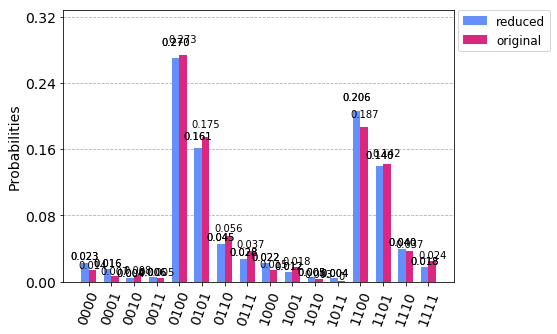

In [9]:
default_thetas = [[ np.random.rand()*5 for j in range(4)] for i in range(4)]
SEED = 11312
NSHOTS = 1024
final_result = get_orig_maxcut_result(4, 1, default_thetas)
print(final_result)
final_result_reduced = get_real_device_reduced_maxcut_result(4,1,default_thetas)
from qiskit.visualization import plot_histogram
plot_histogram([final_result_reduced,final_result], legend=["reduced","original"])

In [12]:
# default_thetas = [[ 1 for j in range(4)] for i in range(4)]
# SEED = 123
# NSHOTS = 1024
# final_result = get_orig_maxcut_result(4, 2, default_thetas)
# final_result_reduced = get_reduced_maxcut_result(4,2,default_thetas)
# from qiskit.visualization import plot_histogram
# plot_histogram([final_result_reduced,final_result], legend=["reduced","original"])

In [34]:
def SPSA_optimization(n, depth, total_test, w,get_result_func):
    global F
    global results
    L = n*depth
    beta = np.ones((L, 1))
    for i in range(0, L):
        beta[i] = 1
    param = [[np.random.rand()*5 for j in range(depth)] for i in range(n)]
    for T in range(1, total_test+1):
        an = 1 / np.power(T, 0.6)
        cn = 0.15 / np.power(T, 1)
        delta = np.random.binomial(1, 0.5, L)*2-1
        #print(delta)
        total = 0 
        for i in range(n):
            for j in range(depth):
                param[i][j] = beta[total] + delta[total]*cn
                total = total + 1
        #print(param)
        
        #final_result_reduced = get_reduced_maxcut_result(n, depth, param)
        #F_plus = get_cost(final_result_reduced, w)
        
        
        final_result = get_result_func(n, depth, param)
        F_plus = get_cost(final_result, w)
        
        total = 0
        for i in range(n):
            for j in range(depth):
                param[i][j] = beta[total] - delta[total]*cn
                total = total + 1
        #final_result_reduced = get_reduced_maxcut_result(n, depth, param)
        #F_minus = get_cost(final_result_reduced, w)
        
        
        final_result = get_result_func(n, depth, param)
        F_minus = get_cost(final_result, w)
        
        for i in range(L):
            beta[i] += an * (F_plus - F_minus) / (2*cn*delta[i])
        F.append(F_minus)
        print(T, ": ", F_minus)
        results = final_result

In [ ]:
SEED = 43521
w = [[0., 1., 1., 1.],[1., 0., 1., 0.],[1., 1., 0., 1.],[1., 0., 1., 0.]]
F = []
results = []
SPSA_optimization(4, 1, 100, w, get_real_device_reduced_maxcut_result)

1 :  1.9735196971525097


In [31]:
print(results)

{'0000': 13720.0, '0001': 0, '0010': 25480.0, '0011': 0, '0100': 33180.0, '0101': 0, '0110': 70840.0, '0111': 140.0, '1000': 86632.0, '1001': 0, '1010': 160888.0, '1011': 0, '1100': 209508.0, '1101': 0, '1110': 447304.0, '1111': 884.0}


In [198]:
[ (val % (6 ** (idx + 1))) // (6 ** idx) for idx in range(3)]

[2, 3, 5]

In [ ]:
default_thetas = [[ i * PI/4 for j in range(4)] for i in range(4)]
cc = make_maxcut_circuit(4,2,default_thetas)
cc.draw()

In [10]:
FINALCOMPARISONDATA = [final_result_reduced,final_result]

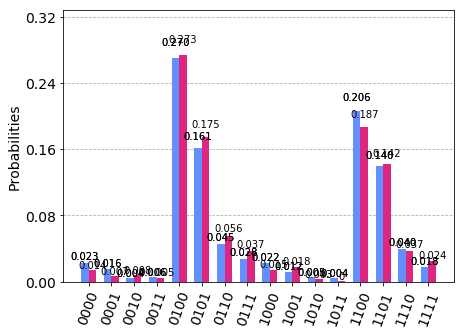

In [11]:
plot_histogram(FINALCOMPARISONDATA)